In [1]:
import numpy as onp
import tensorflow as tf
import matplotlib.pyplot as plt

from utils import *

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


# hyperparameters

In [3]:
#data
DATASET = 'mnist'
class_num   = 10
test_size   = None
train_size  = 512
image_shape = None

if DATASET =='mnist':
    image_shape = (28, 28, 1)
elif DATASET == 'cifar10':
    image_shape = (32, 32, 3)

batch_size = 256
epochs = 50

In [4]:
if DATASET == 'mnist':
    eps = 0.3
    eps_iter_10 = (eps/10)*1.1
    eps_iter_100 = (eps/100)*1.1
    eps_iter_1000 = (eps/1000)*1.1
    
elif DATASET == 'cifar10':
    eps = 0.03
    eps_iter_10 = (eps/10)*1.1
    eps_iter_100 = (eps/100)*1.1

In [5]:
x_train_all, y_train_all, x_test_all, y_test_all = tuple(onp.array(x) for x in get_dataset(DATASET, None, None, 
                                                                                  do_flatten_and_normalize=False))

In [6]:
# shuffle
seed = 0
x_train_all, y_train_all = shaffle(x_train_all, y_train_all, seed)

In [7]:
x_train_all = x_train_all.astype(onp.float32)
x_test_all  = x_test_all.astype(onp.float32)

In [8]:
# down sample
x_train = x_train_all[:train_size]
y_train = y_train_all[:train_size]

x_valid = x_train_all[train_size:]
y_valid = y_train_all[train_size:]

x_test = x_test_all[:test_size]
y_test = y_test_all[:test_size]

In [9]:
x_train, x_valid, x_test = x_train.reshape((-1, *image_shape)), x_valid.reshape((-1, *image_shape)), x_test.reshape((-1, *image_shape))

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(
    100000
).batch(
    batch_size
).prefetch(10)

In [11]:
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(batch_size)

In [12]:
layers = tf.keras.layers

In [13]:
img_input = layers.Input(shape=image_shape)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2),
                  kernel_initializer=tf.keras.initializers.GlorotNormal())(img_input)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2),
                 kernel_initializer=tf.keras.initializers.GlorotNormal())(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2),
                 kernel_initializer=tf.keras.initializers.GlorotNormal())(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal())(x)
out = layers.Dense(10, kernel_initializer=tf.keras.initializers.GlorotNormal())(x)

model = tf.keras.Model(inputs=img_input, outputs=out)

In [14]:
def scheduler(epoch, lr):
    if epoch < 10:
        return 1e-2
    elif epoch < 20:
        return 1e-1
    elif epoch < 60:
        return 1e-1
    else:
        return 1e-4

In [15]:
model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                65600     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650   

In [17]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [18]:
# model.fit(x=train_ds, validation_data=valid_ds, epochs=epochs*2, callbacks=[callback])

In [19]:
model.load_weights('./model_weights/mnist-simple_cnn_stride_thin_train=512-without-DA_ce.h5')

In [20]:
model.evaluate(x=x_test, y=y_test_all, verbose=0)

[1.2019809935068713, 0.8747]

In [21]:
def tangent_feature(model, xs):
    n = len(xs)
    with tf.GradientTape() as tape:
        output = model(xs)
    subgradients = tape.jacobian(output, model.trainable_weights)
    flattened = [tf.reshape(sg, [n, -1]) for sg in subgradients]
    gradients = tf.concat(flattened, 1)
    return gradients

@tf.function
def kernel(model, x, y):
    dot = tf.reduce_sum(tf.multiply(tangent_feature(model, x), tangent_feature(model, y)))
    return dot

In [22]:
ce_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

@tf.function
def targeted_fgsm(x, y_target, model, eps):
    with tf.GradientTape() as tp:
        tp.watch(x)
        y = model(x)
        loss = ce_loss(y_target, y)
    grad = tp.gradient(loss, x)
    return tf.clip_by_value(x - eps * tf.sign(grad), 0, 1)

@tf.function
def untargeted_fgsm(x, y_true, model, eps):
    with tf.GradientTape() as tp:
        tp.watch(x)
        y = model(x)
        loss = ce_loss(y_true, y)
    grad = tp.gradient(loss, x)
    return tf.clip_by_value(x + eps * tf.sign(grad), 0, 1)

In [23]:
from tqdm import tqdm

In [24]:
# onp.save('k_train_train.npy', k_train_train)
# onp.save('k_test_train.npy', k_test_train)

# k_train_train = onp.zeros((train_size, train_size), dtype=onp.float32)

# for i in tqdm(range(train_size)):
#     for j in range(i, train_size):
#         k_train_train[i][j] = kernel(model, x_train[i][None], x_train[j][None])
#         k_train_train[j][i] = k_train_train[i][j]
        
# k_train_train = k_train_train.astype(onp.float64)

In [43]:
# k_train_train = onp.load('k_train_train.npy')
k_train_train_inv = onp.load('k_train_train_inv.npy')

In [26]:
# def inv(k):
#     #inverse with diag_reg
#     return onp.linalg.inv(k + 1e-5 * onp.eye(k.shape[0]))

In [27]:
# k_train_train_inv = inv(k_train_train)

In [28]:
tf.keras.backend.set_floatx('float64')

In [30]:
# for i in range(train_size):
i = 0
x1 = tf.constant(x_test[i])
x1 = tf.reshape(x1, (-1, *image_shape))
with tf.GradientTape() as tp:
    tp.watch(x1)
    k_test_train = tf.stack([kernel(model, x1, x_train[j][None]) for j in range(train_size)],
                            axis=-1)
    k_test_train = tf.reshape(k_test_train, (1, train_size))
    k_test_train = tf.cast(k_test_train, tf.float64)
    
    xy = tf.matmul(k_train_train_inv, y_train[:train_size].astype(onp.float64))
    pred = tf.matmul(k_test_train, xy)
    loss = ce_loss(y_test[i][None], pred)
grad = tp.gradient(loss, x1)

In [38]:
ans = x_test[0][None] + grad.numpy()

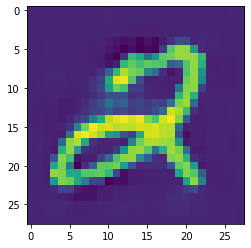

In [39]:
plt.imshow(ans.reshape((28, 28)))

In [41]:
model(ans)

<tf.Tensor: id=74024, shape=(1, 10), dtype=float32, numpy=
array([[-15.940378 ,  -9.592758 ,   2.3942502,  -3.761365 ,  25.623034 ,
          1.480119 ,  -3.2154405,  -3.5626764,  -0.9011345,  19.350779 ]],
      dtype=float32)>